In [1]:
import pandas as pd
import networkx as nx

from node2vec import Node2Vec
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

### Loading the data

In [2]:
resign_df = pd.read_csv('data/ricky_renuncia_hoaxy.csv')
print(f'Shape of data: {resign_df.shape}')
resign_df.head()

Shape of data: (781, 22)


,canonical_url,date_published,domain,from_user_botscore,from_user_id,from_user_screen_name,id,is_mention,original_query,pub_date,...,title,to_user_botscore,to_user_id,to_user_screen_name,tweet_created_at,tweet_id,tweet_type,tweet_url,url_id,url_raw
0,NaN,2019-07-17T14:21:15Z,NaN,0.048114,1115546348,JDC_Cheo,NaN,False,query=%23RickyRenuncia&sort=recent&type=Twitter,2019-07-17T14:21:15Z,...,NaN,0.060780,299044962,LuisYoPR,2019-07-17T14:21:15Z,1151497091778134017,retweet,https://twitter.com/JDC_Cheo/status/1151497091...,NaN,NaN
1,NaN,2019-07-17T14:21:15Z,NaN,0.035083,72021355,MissKabuki,NaN,False,query=%23RickyRenuncia&sort=recent&type=Twitter,2019-07-17T14:21:15Z,...,NaN,0.044479,272627320,Simba_0804,2019-07-17T14:21:15Z,1151497092550078464,retweet,https://twitter.com/MissKabuki/status/11514970...,NaN,NaN
2,NaN,2019-07-17T14:21:16Z,NaN,0.056245,135285845,casapuebloorg,NaN,False,query=%23RickyRenuncia&sort=recent&type=Twitter,2019-07-17T14:21:16Z,...,NaN,0.413570,1123583653341057025,CR_one973,2019-07-17T14:21:16Z,1151497097994051591,retweet,https://twitter.com/casapuebloorg/status/11514...,NaN,NaN
3,NaN,2019-07-17T14:21:17Z,NaN,0.029914,724444922,carlacamach0,NaN,False,query=%23RickyRenuncia&sort=recent&type=Twitter,2019-07-17T14:21:17Z,...,NaN,0.158817,372488887,NMRiveraRivera,2019-07-17T14:21:17Z,1151497102339579904,retweet,https://twitter.com/carlacamach0/status/115149...,NaN,NaN
4,NaN,2019-07-17T14:21:17Z,NaN,NaN,2582567569,AliceaDaliana,NaN,False,query=%23RickyRenuncia&sort=recent&type=Twitter,2019-07-17T14:21:17Z,...,NaN,NaN,1002648264724926465,nydielis06,2019-07-17T14:21:17Z,1151497103107121153,retweet,https://twitter.com/AliceaDaliana/status/11514...,NaN,NaN


In [3]:
nodes_df = resign_df[['from_user_botscore', 'from_user_screen_name', 'to_user_botscore', 'to_user_screen_name']]
nodes_df.head()

,from_user_botscore,from_user_screen_name,to_user_botscore,to_user_screen_name
0,0.048114,JDC_Cheo,0.060780,LuisYoPR
1,0.035083,MissKabuki,0.044479,Simba_0804
2,0.056245,casapuebloorg,0.413570,CR_one973
3,0.029914,carlacamach0,0.158817,NMRiveraRivera
4,NaN,AliceaDaliana,NaN,nydielis06


## Creating graph from edgelist

/home/kropotkin/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


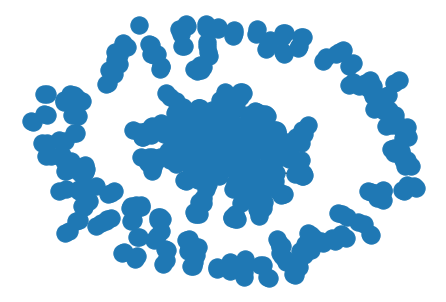

In [4]:
resign_graph = nx.from_pandas_edgelist(nodes_df, source = 'from_user_screen_name', target = 'to_user_screen_name')
nx.draw(resign_graph)

## Fitting Node2Vec

In [5]:
node2vec = Node2Vec(resign_graph, dimensions = 64, walk_length = 10, num_walks = 200, workers = 4)

Computing transition probabilities: 100%|██████████| 816/816 [00:00<00:00, 9965.10it/s]


In [6]:
model = node2vec.fit(window = 10, min_count = 1, batch_words = 4)

#### Evaluating Node2Vec learned 'correctly'

In [7]:
model.wv.most_similar('ilevitable')

[('sanbenito', 0.5686574578285217),
 ('Residente', 0.5156399011611938),
 ('plainjane32', 0.479981392621994),
 ('jamie924', 0.4763683080673218),
 ('PepoWoodz', 0.4661406874656677),
 ('SuheillyR', 0.46509289741516113),
 ('MrTonitas', 0.46462482213974),
 ('Torreshl76', 0.4621414840221405),
 ('MilkyWhiteTY', 0.45918554067611694),
 ('ingemorales_pr', 0.45273247361183167)]

### Extracting embeddings

In [8]:
vocabulary = list(model.wv.vocab.keys())

embeddings = {}

for user in vocabulary:
    embeddings.update({user: model.wv[user]})

In [9]:
embeddings_df = pd.DataFrame.from_dict(embeddings, orient = 'index')

## Reducing embeddings dimensions

In [10]:
pca = PCA(n_components = 2)
pca.fit(embeddings_df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [11]:
pca_components = pd.DataFrame(pca.transform(embeddings_df))
pca_components.index = embeddings_df.index

In [12]:
users_botscore = {}

for user in vocabulary:
    botscore =  resign_df.query(f"from_user_screen_name == '{user}'").from_user_botscore.unique()
    users_botscore.update({user: botscore})
    
for user in vocabulary:
    if users_botscore[user].size == 0:
        botscore =  resign_df.query(f"to_user_screen_name == '{user}'").to_user_botscore.unique()
        users_botscore.update({user: botscore})

In [13]:
users_info = pd.DataFrame.from_dict(users_botscore, orient='index', columns=['botscore'])
user_pca = pd.concat([pca_components, users_info], axis = 1)

## Visualizing Node Embeddings

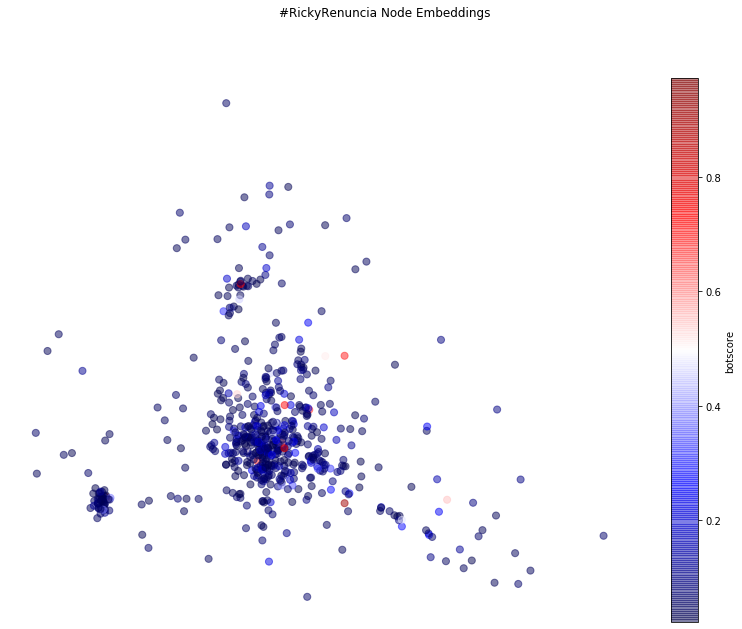

In [14]:
user_pca.plot(x = 0, y = 1, kind = 'scatter', c = 'botscore', 
              s = 50, figsize = (14, 10), cmap = cm.seismic, 
              alpha = 0.5)

plt.axis('off')
plt.suptitle('#RickyRenuncia Node Embeddings')
plt.savefig('imgs/renuncia_embeddings.png')

## K Means Clustering

In [15]:
from sklearn.cluster import KMeans

In [16]:
k = range(2, 30)
inertia = []

for i in k:
    kmeans = KMeans(n_clusters=i, random_state=2019)
    kmeans.fit(embeddings_df)
    inertia.append(kmeans.inertia_)

### Looking at the inertia of the method with each k

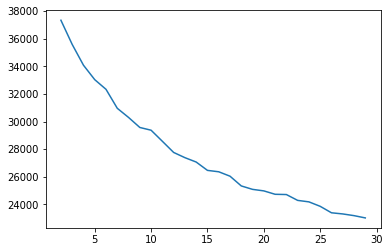

In [17]:
plt.plot(k, inertia);

## Using Gaussian Mixture Models to compare with K Means

In [18]:
from sklearn import mixture

In [19]:
aic = []
bic = []

for i in k:
    gmm = mixture.GaussianMixture(n_components = i, random_state=2019)
    gmm.fit(embeddings_df)
    aic.append(gmm.aic(embeddings_df))
    bic.append(gmm.bic(embeddings_df))

#### Looking at AIC

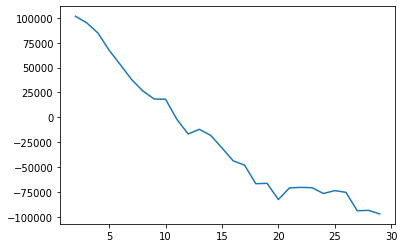

In [20]:
plt.plot(k, aic);

#### Looking at BIC

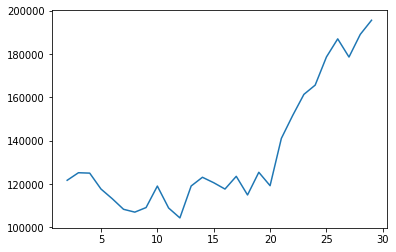

In [21]:
plt.plot(k, bic);

In [22]:
kmeans = KMeans(n_clusters=20, random_state=2019)
kmeans.fit(embeddings_df);

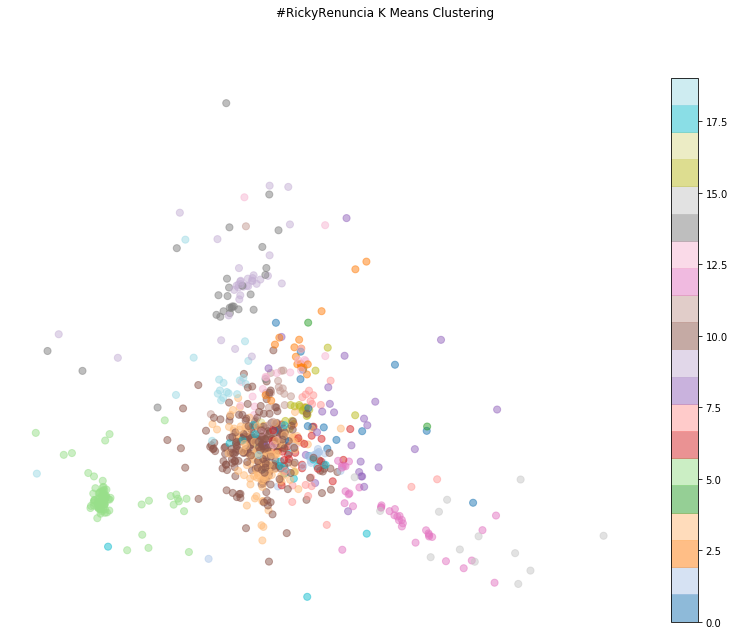

In [26]:
user_pca.plot(x = 0, y = 1, kind = 'scatter', c = kmeans.labels_, 
              s = 50, figsize = (14, 10), cmap = cm.tab20, 
              alpha = 0.5)

plt.axis('off')
plt.suptitle('#RickyRenuncia K Means Clustering')
plt.savefig('imgs/renuncia_kmeans_clustering.png')